<font color=darkred>
    
# Soc 220: Computational Text Analysis
## Lab 9: Topic Models III

***

<img src="images/minard.jpg" style="width: 650px"/>


***

Today:

1. Review topic model basics
2. Introduction to the gensim library
2. User-friendly vanilla LDA
3. Help with STM in R.
3. Dynamic topic models.

***

### 1.  REVIEW

#### <font color=purple> Here's a cartoon example: </font color=purple>

<img src="images/simple_example.png" style="width: 500px" />

We care about calculating two probability values:

- **P( word | topics)**
- **P( topics | documents)**

*n.b. We are specifying number of topics in advance.*

Doc 1 is about food (aka topic A). Doc 2 is about pets (topic B). Doc 3 is about topic A and topic B. Let's say that the algorithm has arrived at the word $\text{fish}_{d3}$ (the word fish in document 3). What should it do now?

First, we calculate the probability of the word appearing in the different topics. Thus far we have observed 4 `fish` and in 3/4 cases, classified as topic A (N plate):

- P('fish' | topic A) = 0.75
- P('fish' | topic B) = 0.25

Next, we calculate per document probability (M plate):

- P(topic A | doc 3) = 0.5
- p(topic A | doc 3) = 0.5

Since $0.5 * 0.75 = 0.375 > 0.5 * 0.25 = . 125$, we assign $\text{fish}_{d3}$ to topic A.

<img src="images/lda_plate.png" style="width: 600px" />


1. Choose a topic $z_n ~ \text{Multinomial}(\theta)$ where $\theta$ is the topic distribution for that document.
2. Choose a word $w_n$ from p ($w_n | z_n, \beta)$, where $\beta$ is the number of topics across the corpus.

So, in each step, we're calculating given the set of all possible topics and the appearance of words in a given doc, how likely is each topic. And we update our per-word topic assignment.

The likelihood of any given word being associated with any given topic is thus the sum of all previous p(word | topic), and thus:

The objective function for which it is finding the maximum log-likelihood that given a new word $w_{n+1}$, it can identify the associated topic.

Lastly for intuition:

- $\alpha$ (topic distribution) really means **document-topic density**, so a higher $\alpha$ means **more specific topic distributions per document**.
- While $\beta$ (topics across corpus) really means **topic-word density**, so a higher (or lower) $\beta$ means more specific word distribution per topic.

One can think of both as a granularity measure.

Blei's useful presentation: https://www.slideshare.net/ajayohri/modeling-science

Cartoon example stolen from: https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df

***

#### 2. gensim

gensim is a library for implementing a wide variety of topic models (as well as word embeddings).

It requires two objects:

1. A dictionary object which takes in a list of strings. This object assigns a unique ID to each word.

2. Then, that dictionary object is used to create a corpus (in our case, a bag of words).

In [1]:
#!pip3 install gensim

In [2]:
from gensim.corpora import Dictionary
import numpy as np

In [3]:
texts = [
        ['bank','river','shore','water'],
        ['river','water','flow','fast','tree'],
        ['bank','water','fall','flow'],
        ['bank','bank','water','rain','river'],
        ['river','water','mud','tree'],
        ['money','transaction','bank','finance'],
        ['bank','borrow','money'], 
        ['bank','finance'],
        ['finance','money','sell','bank'],
        ['borrow','sell'],
        ['bank','loan','sell','bank']
]

#use Dictionary to create the mapping of each word to an ID.
dictionary = Dictionary(texts)

#
dictionary.token2id

{'bank': 0,
 'borrow': 13,
 'fall': 7,
 'fast': 4,
 'finance': 10,
 'flow': 5,
 'loan': 15,
 'money': 11,
 'mud': 9,
 'rain': 8,
 'river': 1,
 'sell': 14,
 'shore': 2,
 'transaction': 12,
 'tree': 6,
 'water': 3}

In [4]:
#Then the corpus is created from the dictionary object itterated on the original list of strings. 
corpus = [dictionary.doc2bow(text) for text in texts]

In [5]:
#Let's look at the fourth doc

#Notice that it counts the first unique word (bank) assigned to 0 and then it has a tuple for the count.
corpus[3]

[(0, 2), (1, 1), (3, 1), (8, 1)]

In [6]:
#pull in the model command from the gensim.models library
from gensim.models import ldamodel

#the ldamodel has a couple of different variations/options
#dir(ldamodel)

In [7]:
#the default version:
lda_model = ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2)

In [8]:
# the show_topics method prints words and the probability that a given word is associated with that topic
lda_model.show_topics()

[(0,
  '0.180*"bank" + 0.119*"money" + 0.106*"finance" + 0.096*"sell" + 0.086*"borrow" + 0.056*"water" + 0.050*"transaction" + 0.046*"river" + 0.041*"tree" + 0.039*"flow"'),
 (1,
  '0.203*"bank" + 0.143*"water" + 0.119*"river" + 0.063*"flow" + 0.062*"tree" + 0.051*"sell" + 0.043*"shore" + 0.043*"fall" + 0.043*"finance" + 0.042*"fast"')]

In [9]:
# the get_term_topics takes in a word and then prints the normalized probability p(word | topic)
lda_model.get_term_topics('water')

[(0, 0.037886627), (1, 0.12978822)]

In [10]:
lda_model.get_term_topics('bank')

[(0, 0.16380008), (1, 0.19027601)]

In [11]:
lda_model.get_term_topics('money')

[(0, 0.10173138), (1, 0.019432375)]

#### pyLDAvis

Same as last time, but we have to use the gensim variant (instead of the sklearn).

In [12]:
#!pip3 install pyLDAvis

In [13]:
import pyLDAvis
import pyLDAvis.gensim
#takes in a special gensim command with (1) fitted model, (2) corpus, and (3) dictionary
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


***

<font color=purple>

### <center>3.  HANDS ON VANILLA LDA -- YOUR DATA GOES HERE </center>

***

In [14]:
import pickle
df_texts = pickle.load(open("df_proceedings_monarch_and_date.p","rb"))

In [15]:
import pandas as pd
df_texts.head()

,date,monarch,text
0,1660_11,charles2,On the sixth of November the Parliament met ac...
1,1660_4,charles2,"CHARLES R."", ""Trusty, and Wellbeloved, We gree..."
2,1661_11,charles2,After a Recess of almost four Months the Parli...
3,1661_5,charles2,"On the 8th of May the new Parliament met, and ..."
4,1663_2,charles2,"On February 18, 16623. the Parliament met afte..."


In [16]:
# IF YOU HAVEN'T CREATED EXCEL TO SEND OVER TO R YET..
#write to excel in order to retain complexity of text
writer = pd.ExcelWriter('df_proceedings_monarch_and_date.xlsx')
df_texts.to_excel(writer,'Sheet1')

***

<font color=purple>

### <center>Interlude here for those who wish to do STM </center>

***

<font color=darkred>
    
#### A little data cleaning

In [17]:
punctuation=['(', ')', '?', ':', ';', ',', '.', '!', '/', '"', "'","''",'``',"£",
             '!', '#', '$', '%', '&', '(', ')', '*', '+', '-', '/', ':','|', '}',
             ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{','~']

english_stops = [
 'i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 'not',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 's',
 't',
 'can',
 'will',
 'just',
 'don',
 'should',
 'now',
 'd',
 'll',
 'm',
 'o',
 're',
 've',
 'y',
 'ain',
 'aren',
 'couldn',
 'didn',
 'doesn',
 'hadn',
 'hasn',
 'haven',
 'isn',
 'ma',
 'mightn',
 'mustn',
 'needn',
 'shan',
 'shouldn',
 'wasn',
 'weren',
 'won',
 'wouldn',
 'may',
 'upon',
 'made',
 'must',
 'said',
 'therefore',
 'shall',
 ]

In [18]:
from nltk.tokenize import word_tokenize
list_tokens = df_texts.text.apply(word_tokenize)

proceedings_clean = []

for proceeding in list_tokens:
    
    #lowercase
    tokens = [w.lower() for w in proceeding]
    
    #stop words
    tokens = [w for w in proceeding if not w in english_stops]
    
    #remove punctuation
    tokens = [w for w in tokens if not w in punctuation]
    
    #remove digits
    tokens = [w for w in tokens if not w.isdigit()]
    
    #remove < 3
    tokens = [w for w in tokens if len(w) > 3]
    
    proceedings_clean.append(tokens)

In [19]:
# data check
proceedings_clean[1][100:125]

['confident',
 'That',
 'believe',
 'find',
 'Preservation',
 'King',
 'Authority',
 'necessary',
 'Preservation',
 'Parliaments',
 'Name',
 'right',
 'Constitution',
 'prepare',
 'apply',
 'proper',
 'Remedies',
 'Evils',
 'grievous',
 'People',
 'thereby',
 'establish',
 'Peace',
 'Security',
 'least']

In [20]:
# create gensim dictionary
proceedings_dict = Dictionary(proceedings_clean)

In [21]:
# 24783 unique tokens
len(proceedings_dict)

24783

In [22]:
# the dictionary object has methods to shrink it

proceedings_dict.filter_extremes(no_below=5,no_above=0.99)

https://radimrehurek.com/gensim/corpora/dictionary.html

filter_extremes(no_below=5, no_above=0.5, keep_n=100000, keep_tokens=None)

Filter tokens in dictionary by frequency.

Parameters:	
- no_below (int, optional) – Keep tokens which are contained in at least no_below documents.
- no_above (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
- keep_n (int, optional) – Keep only the first keep_n most frequent tokens.
- keep_tokens (iterable of str) – Iterable of tokens that must stay in dictionary after filtering.

In [23]:
# check again for length of dictionary
len(proceedings_dict)

7721

In [24]:
# now for the gensim corpus object
# apply dictionary to each text 
proceedings_corp = [proceedings_dict.doc2bow(proceeding) for proceeding in proceedings_clean]

https://radimrehurek.com/gensim/models/ldamodel.html

`class gensim.models.ldamodel.LdaModel(corpus=None, num_topics=100, id2word=None, distributed=False, chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001, minimum_probability=0.01, random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None, dtype=<type 'numpy.float32'>)`

use `%%time` in a cell to calculate how long it takes to compute a given model.

In [25]:
from gensim.models.ldamodel import LdaModel

proceedings_lda = LdaModel(
    corpus=proceedings_corp, 
    id2word=proceedings_dict,
    num_topics=5,               # how many topics
    #chunkzie = 1500,            # how many documents to grab at once
    offset=50,                  # learning offset which tells the model to `burn-in` on the MCMC before starting to save
    minimum_probability = .01,  # filtering the topics returned
    passes=20,                  # the number of 'laps' through the corpus. More passes means better model, but at the expense of computation
    random_state = 1,           # generate from the same random variable so you can reproduce your results
    #iterations = 50            # for super complex ones, this sets a maximum number of itterations (rather than a convergence to stop)
)

In [26]:
# visualize same as before

import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(proceedings_lda, proceedings_corp, proceedings_dict)
pyLDAvis.display(vis)

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [27]:
# the actual fitted model also has some methods for extracting topic and term information.
#dir(proceedings_lda)

In [28]:
# it also has a built pickler
proceedings_lda.save('vanilla_model1')

In [29]:
proceedings_lda.print_topics()

[(0,
  '0.016*"House" + 0.011*"Lords" + 0.011*"Commons" + 0.010*"That" + 0.007*"Bill" + 0.006*"would" + 0.005*"hath" + 0.004*"time" + 0.004*"Lordships" + 0.004*"\'That"'),
 (1,
  '0.005*"House" + 0.004*"would" + 0.002*"Commons" + 0.002*"That" + 0.002*"Bill" + 0.002*"People" + 0.002*"Time" + 0.002*"might" + 0.002*"Gentlemen" + 0.002*"\'That"'),
 (2,
  '0.018*"House" + 0.012*"That" + 0.006*"Commons" + 0.006*"\'That" + 0.006*"Bill" + 0.006*"Committee" + 0.006*"would" + 0.005*"Year" + 0.005*"several" + 0.004*"read"'),
 (3,
  '0.004*"House" + 0.003*"would" + 0.003*"That" + 0.002*"much" + 0.002*"think" + 0.002*"Bill" + 0.002*"Time" + 0.002*"without" + 0.002*"Nation" + 0.002*"People"'),
 (4,
  '0.010*"would" + 0.009*"House" + 0.007*"People" + 0.006*"Nation" + 0.006*"Time" + 0.006*"think" + 0.006*"every" + 0.006*"present" + 0.006*"much" + 0.006*"Gentleman"')]

In [30]:
proceedings_lda.print_topic(2)

'0.018*"House" + 0.012*"That" + 0.006*"Commons" + 0.006*"\'That" + 0.006*"Bill" + 0.006*"Committee" + 0.006*"would" + 0.005*"Year" + 0.005*"several" + 0.004*"read"'

***
***

### 4. DYNAMIC TOPIC MODELS

Here's a key intuition:

1. Are you using topic models to explain some outcome (STM)?
2. Is the topic model itself the outcome worth explaining? In this case, DTM makes sense.

https://radimrehurek.com/gensim/models/ldaseqmodel.html

All we need for gensim is a split of which docs into which time periods.

<img src="images/dtm_plates.png" style="width: 500px" />

**DOCUMENTS MUST BE IN CHRONOLOGICAL ORDER**

I did a modified version of monarch-to-monarch splits. For me: pre-Glorious Revolution, post-Glorious Revoution to Queen Anne and Treaty of Union, and then from her inauguration to the South Sea Bubble, and then post-South Sea Bubble.

<font color=purple>
    
#### This will take a while. Sometimes several days. GET A RCE ACCOUNT.

https://github.com/RaRe-Technologies/gensim/issues/1545

In [31]:
len(df_texts.date.tolist()[:28])

28

In [32]:
len(df_texts.date.tolist()[28:44])

16

In [33]:
len(df_texts.date.tolist()[44:79])

35

In [34]:
len(df_texts.date.tolist()[80:])

31

In [35]:
%%time
from gensim.models.ldaseqmodel import LdaSeqModel

proceedings_dtm1 = LdaSeqModel(corpus = proceedings_corp,
                               id2word = proceedings_dict,
                               time_slice = [28,16,35,31],
                               num_topics=4,
                               random_state = 1
                              )

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


CPU times: user 1h 29min 51s, sys: 13.8 s, total: 1h 30min 5s
Wall time: 1h 29min 59s


In [36]:
# pickle it
proceedings_dtm1.save("proceedings_dtm1")

In [37]:
proceedings_dtm1.load('proceedings_dtm1')

In [38]:
#dir(proceedings_dtm1)

<font color=darkblue>
    
Our results are in two interesting dimensions:

1. Prevalance of topics over time.
2. Evolution of particular topics.

In [39]:
# we can use the same static visualizer as before and ldaseqmodel has a method for us to pop out what we need:

doc_topic,topic_term,doc_lengths,term_frequency,vocab = proceedings_dtm1.dtm_vis(time=0, corpus=proceedings_corp)

vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)

pyLDAvis.display(vis_wrapper)

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [40]:
# for time period 2
doc_topic,topic_term,doc_lengths,term_frequency,vocab = proceedings_dtm1.dtm_vis(time=1, corpus=proceedings_corp)

vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)

pyLDAvis.display(vis_wrapper)

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [ ]:
# doc_topics checks the topic proportions on documents already trained on. accecpts document number as input
proceedings_dtm1.doc_topics(0)

In [41]:
# extract the arrays of topic proportions
list_topic_proportions = []

for i in range(len(df_texts.date)):
    list_topic_proportions.append(proceedings_dtm1.doc_topics(i))

In [42]:
# create a dataframe from that list of arrays and also name some columns
topic_dist_df = pd.DataFrame(list_topic_proportions,columns=['religion','governance','war','finance'])

In [43]:
topic_dist_df.head()

,religion,governance,war,finance
0,0.566429,0.077754,0.294400,0.061417
1,0.661556,0.029880,0.189500,0.119064
2,0.689737,0.062891,0.166997,0.080374
3,0.744360,0.021994,0.157223,0.076424
4,0.808603,0.014544,0.117893,0.058960


In [44]:
#from lab 8:

In [45]:
# join to original dataframe
df_texts_topics = topic_dist_df.join(df_texts)
df_texts_topics.head()

,religion,governance,war,finance,date,monarch,text
0,0.566429,0.077754,0.294400,0.061417,1660_11,charles2,On the sixth of November the Parliament met ac...
1,0.661556,0.029880,0.189500,0.119064,1660_4,charles2,"CHARLES R."", ""Trusty, and Wellbeloved, We gree..."
2,0.689737,0.062891,0.166997,0.080374,1661_11,charles2,After a Recess of almost four Months the Parli...
3,0.744360,0.021994,0.157223,0.076424,1661_5,charles2,"On the 8th of May the new Parliament met, and ..."
4,0.808603,0.014544,0.117893,0.058960,1663_2,charles2,"On February 18, 16623. the Parliament met afte..."


In [46]:
#plot changes in topics over time

import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 5))

plt.plot(df_texts_topics.date,df_texts_topics['religion'],color='blue')
plt.plot(df_texts_topics.date,df_texts_topics['governance'],color='red')
plt.plot(df_texts_topics.date,df_texts_topics['war'],color='purple')
plt.plot(df_texts_topics.date,df_texts_topics['finance'],color='green')

plt.xticks(df_texts.date[::], rotation=45,size=7)
plt.title('topic proportions over time')
plt.legend(['religion','governance','war','finance'])
plt.grid()
plt.show()

<font color = darkgreen>
    
#### On a future date, below should become its own function.

In [47]:
# evolution of 1st topic
proceedings_dtm1.print_topic_times(topic=0)

[[('House', 0.014676850114809105),
  ('Lords', 0.012071617135702829),
  ('Commons', 0.01117363917134312),
  ('That', 0.007516653448000062),
  ('Bill', 0.006885126931048216),
  ('would', 0.006653204477834682),
  ('hath', 0.005241058249858117),
  ('Lordships', 0.004857201873749719),
  ('time', 0.004496323651525568),
  ('think', 0.0043548953111142725),
  ('Lord', 0.003902902597959605),
  ('Religion', 0.0038829008861271763),
  ('Government', 0.0037839734060223307),
  ('without', 0.003660687833244246),
  ('Right', 0.003620939309394413),
  ('take', 0.003599374685447495),
  ('much', 0.003544634394309356),
  ('England', 0.0035352395534370556),
  ('Case', 0.0034350445457126846),
  ('Persons', 0.0034174023465949376)],
 [('House', 0.014839414555341391),
  ('Lords', 0.012204496604313166),
  ('Commons', 0.011341363196979875),
  ('That', 0.007406661284348831),
  ('Bill', 0.006986884056061639),
  ('would', 0.0066418382814180344),
  ('hath', 0.005217546153590103),
  ('Lordships', 0.0049187884767332496

In [48]:
list_lists = []

for proceeding in proceedings_dtm1.print_topic_times(topic=0):
        list_words = []
        list_freqs = []
        
        for word, freq in proceeding:
            list_words.append(word)
            list_freqs.append(freq)
            
        list_lists.append(list_words)
        list_lists.append(list_freqs)

In [54]:
topic0_df = pd.DataFrame(list_lists[:2]) 
topic0_df = topic0_df.T
topic0_df = topic0_df.rename(columns = {0:'token',1:'p1'})

topic1_df = pd.DataFrame(list_lists[2:4]) 
topic1_df = topic1_df.T
topic1_df = topic1_df.rename(columns = {0:'token',1:'p2'})

topic2_df = pd.DataFrame(list_lists[4:6]) 
topic2_df = topic2_df.T
topic2_df = topic2_df.rename(columns = {0:'token',1:'p3'})

topic3_df = pd.DataFrame(list_lists[6:]) 
topic3_df = topic3_df.T
topic3_df = topic3_df.rename(columns = {0:'token',1:'p4'})

In [50]:
df_list = [topic0_df,topic1_df,topic2_df,topic3_df]

In [51]:
from functools import reduce
# reduce applies a function through a list
# merge first item to second item, on the 'token' column. the df_list is a list of the dataframes
period0_df = reduce(lambda x, y: pd.merge(x, y, on = 'token'), df_list)
period0_df

,token,phi1,phi2,phi3,phi4
0,House,0.0146769,0.0148394,0.0151274,0.0152956
1,Lords,0.0120716,0.0122045,0.0124462,0.0125756
2,Commons,0.0111736,0.0113414,0.0116289,0.0117888
3,That,0.00751665,0.00740666,0.0062661,0.00573534
4,Bill,0.00688513,0.00698688,0.00631555,0.00618876
5,would,0.0066532,0.00664184,0.00666808,0.00668716
6,hath,0.00524106,0.00521755,0.00522531,0.0052281
7,Lordships,0.0048572,0.00491879,0.00503434,0.00508862
8,time,0.00449632,0.00465452,0.00483681,0.00493155
9,think,0.0043549,0.00439258,0.0044731,0.00451781


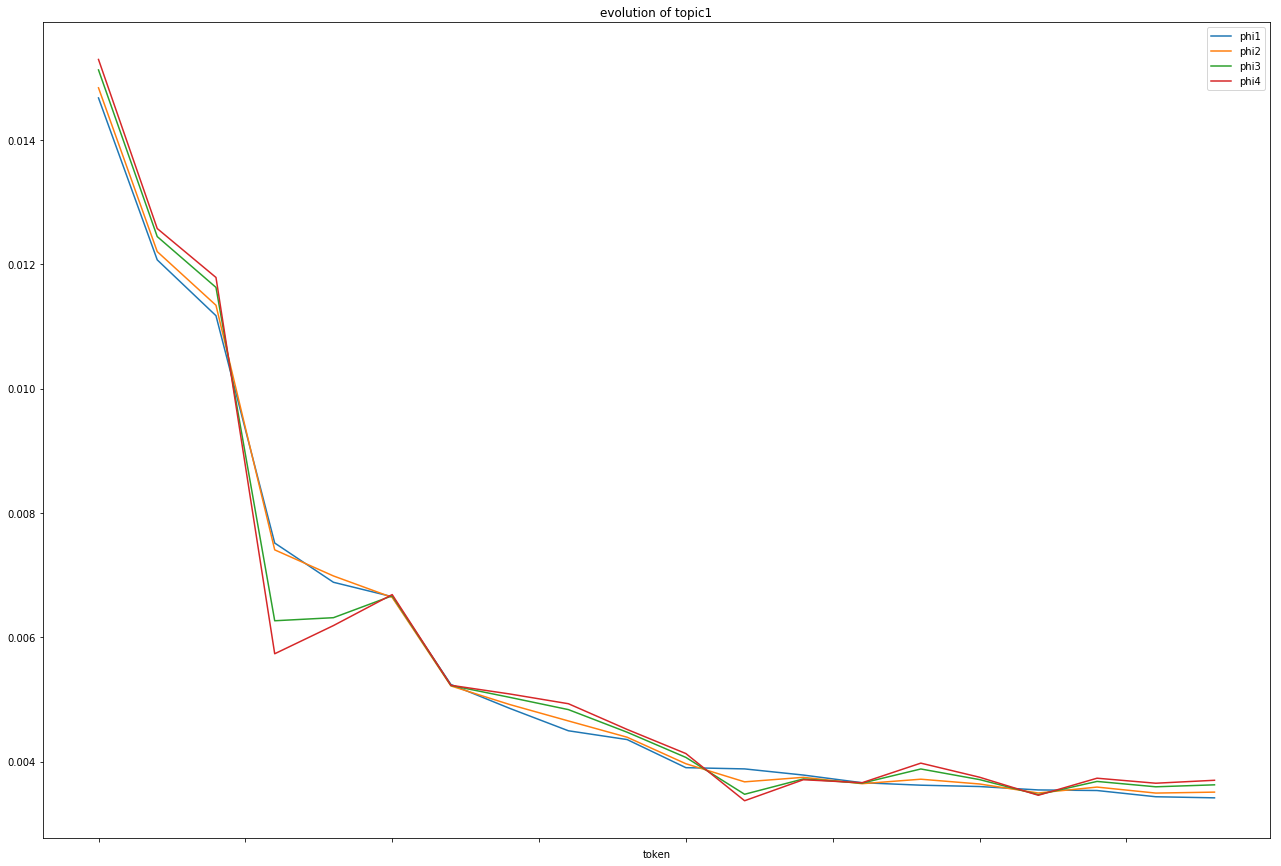

In [52]:
period0_df.plot(x=period0_df.token,figsize=(22,15),title='evolution of topic1')

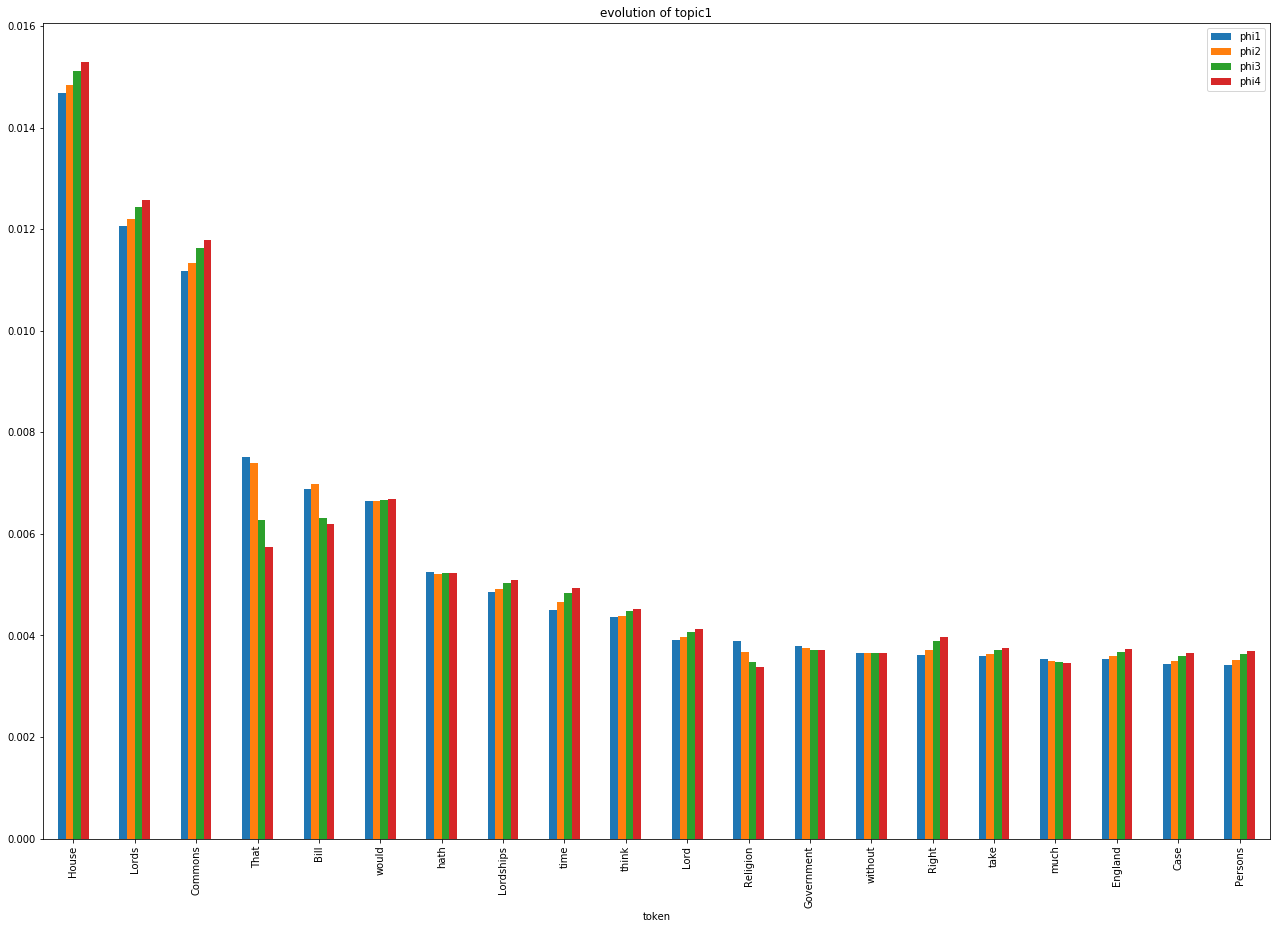

In [53]:
period0_df.plot(x=period0_df.token,kind='bar',figsize=(22,15),title='evolution of topic1')